In [426]:
from pyomo.environ import *
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Modelo Matemático para la Optimización de Rutas de Inspección

## Conjuntos

- **K**: Conjunto de equipos de inspección.
  
- **N**: Conjunto de localidades.
  
- **$ N_k $**: Conjunto de localidades asignadas al equipo k. **NOTA: En el conjunto siempre debe estar la localidad de inicio del equipo**

## Parámetros

- **$ c_{ij} $**: Costo de desplazamiento entre la localidad i  y la localidad j.

- **$ s_k $**: Localidad de inicio del equipo k.

## Variables de Decisión

- **$ x_{ijk} $**: Variable binaria que indica si el equipo k viaja de la localidad i a la localidad j.

- **$ u_{ik} $**: Variable auxiliar para evitar subtours en la ruta del equipo k.




In [427]:


def crear_modelo(K, N, N_k, c, s_k):
    model = ConcreteModel()

    # Conjuntos
    model.K = Set(initialize=K)  # Equipos
    model.N = Set(initialize=N)  # Localidades
    model.N_k = Set(model.K, initialize=lambda model, k: N_k[k]) # Localidades por equipo

    # Parámetros
    model.c = Param(model.N, model.N, initialize=c)  # Costos
    model.s_k = Param(model.K, initialize=s_k, within=model.N)  # Localidad de inicio/fin de cada equipo


    # Variables
    model.x = Var(model.N, model.N, model.K, within=Binary)
    model.u = Var(model.N, model.K, within=NonNegativeReals)
    return model



## Función Objetivo

Minimizar el costo total de desplazamiento de los equipos de inspección:

$$
\min \sum_{k \in K} \sum_{i \in N} \sum_{j \in N} c_{ij} \cdot x_{ijk}
$$


In [428]:

# Función Objetivo
def obj_rule(model):
    return sum(model.c[i,j] * model.x[i,j,k] for k in model.K for i in model.N_k[k] for j in model.N_k[k])


## Restricciones

1. **Restricción de Salida de Cada Ciudad:**

   Cada equipo debe salir exactamente una vez de cada ciudad asignada:

   $$
   \sum_{j \in N_k} x_{ij,k} = 1 \quad \forall i \in N_k, \, k \in K
   $$

2. **Restricción de Entrada a Cada Ciudad:**

   Cada equipo debe llegar exactamente una vez a cada ciudad asignada:

   $$
   \sum_{i \in N_k} x_{ij,k} = 1 \quad \forall j \in N_k, \, k \in K
   $$

3. **Restricción de Flujo:**

   El flujo de entrada y salida debe ser igual para cada equipo en cada ciudad (excepto la ciudad de inicio):

   $$
   \sum_{j \in N_k} x_{ij,k} = \sum_{j \in N_k} x_{ji,k} \quad \forall i \in N_k, \, i \neq s_k, \, k \in K
   $$

4. **Restricción de Subtours (MTZ - Miller-Tucker-Zemlin):**

   Evitar que se formen ciclos dentro de la ruta, asegurando que cada equipo complete un único ciclo:

   $$
   u_{i,k} - u_{j,k} + |N_k| \cdot x_{ij,k} \leq |N_k| - 1 \quad \forall i \neq j, \, i, j \in N_k, \, k \in K
   $$


In [429]:
def leave_city_rule(model, i, k):
    if i in model.N_k[k]:
    # Solo itera sobre los nodos asociados al equipo k
        return sum(model.x[i, j, k] for j in model.N_k[k] if j != i) == 1
    else:
        return Constraint.Skip






# Restricción 2: Cada ciudad recibe exactamente una visita
def arrive_city_rule(model, j, k):
    if j in model.N_k[k]:
    # Solo itera sobre los nodos asociados al equipo k
        return sum(model.x[i, j, k] for i in model.N_k[k] if i != j) == 1
    else:
        return Constraint.Skip



In [430]:
def flow_rule(model, i, k):
    if i != model.s_k[k] and i in model.N_k[k]:
        return sum(model.x[i, j, k] for j in model.N_k[k]) == sum(model.x[j, i, k] for j in model.N_k[k])
    else:
        return Constraint.Skip




In [431]:

def mtz_rule(model, i, j, k):
    if i != j and i != model.s_k[k] and j != model.s_k[k] and i in model.N_k[k] and j in model.N_k[k]:
        return model.u[i, k] - model.u[j, k] + len(model.N_k[k]) * model.x[i, j, k] <= len(model.N_k[k]) - 1
    else:
        return Constraint.Skip




In [432]:
def graficar_solucion(model):

    G = nx.DiGraph()

    for i in model.N:
        G.add_node(i)

    for k in model.K:
        for i in model.N:
            for j in model.N:
                if model.x[i, j, k].value == 1:
                    G.add_edge(i, j, weight=model.c[i, j], team=k)

    pos = nx.shell_layout(G)

    nx.draw_networkx_nodes(G, pos, node_size=600, node_color='lightblue')


    nx.draw_networkx_labels(G, pos, font_size=12)

    colors = ['red','green','blue','pink','orange','cyan','purple','yellow']

    # Dibujar las aristas y crear la leyenda
    legend_handles = []  # Lista para almacenar las leyendas
    for k in model.K:
        edges_k = [(i, j) for i, j in G.edges if G[i][j]['team'] == k]
        nx.draw_networkx_edges(G, pos, edgelist=edges_k, width=2, edge_color=colors[k-1], arrows=True)
        
        # Agregar una entrada a la leyenda para cada equipo
        legend_handles.append(mpatches.Patch(color=colors[k-1], label=f'Equipo {k}'))

    # Dibujar las etiquetas de las aristas (costos de las rutas)
    edge_labels = {(i, j): f"{G[i][j]['weight']}" for i, j in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Mostrar la leyenda en la parte superior derecha del gráfico
    plt.legend(handles=legend_handles, loc='best')


    for k in model.K:
        edges_k = [(i, j) for i, j in G.edges if G[i][j]['team'] == k]
        nx.draw_networkx_edges(G, pos, edgelist=edges_k, width=2, edge_color=colors[k-1], arrows=True)

    # Dibujar las etiquetas de las aristas (costos de las rutas)
    edge_labels = {(i, j): f"{G[i][j]['weight']}" for i, j in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Mostrar el gráfico
    plt.title(f"Rutas Óptimas para {len(model.K)} equipos")
    plt.show()


In [433]:
def imprimir_resultados(model):
    for k in model.K:
        # Calcular el costo total del equipo k
        costo_equipo = sum(model.c[i, j] * model.x[i, j, k].value for i in model.N for j in model.N if model.x[i, j, k].value == 1)

        # Encontrar el nodo de inicio
        nodo_inicio = model.s_k[k]

        # Obtener la ruta recorrida por el equipo k
        nodo_actual = nodo_inicio
        ruta = [nodo_actual]  # Comenzar la ruta con el nodo inicial
        nodos_visitados = set(ruta)  # Usar un conjunto para rastrear nodos visitados

        # Construir la secuencia de nodos visitados
        while True:
            encontrado = False
            for j in model.N:
                if model.x[nodo_actual, j, k].value == 1:
                    if j in nodos_visitados:  # Evitar ciclos
                        continue
                    ruta.append(j)
                    nodos_visitados.add(j)
                    nodo_actual = j
                    encontrado = True
                    break
            if not encontrado:
                break

        # Mostrar la información del equipo
        print(f"Equipo {k}:")
        print(f"  Costo Total: {costo_equipo}")
        print(f"  Nodo de Inicio: {nodo_inicio}")
        print(f"  Ruta Recorrida: {' -> '.join(map(str, ruta))}")

In [434]:
def ejecutar_modelo(K, N, N_k, c, s_k):
    
    model = crear_modelo(K, N, N_k, c, s_k)
    model.obj = Objective(rule=obj_rule, sense=minimize)

    model.leave_city = Constraint(model.N, model.K, rule=leave_city_rule)
    model.arrive_city = Constraint(model.N, model.K, rule=arrive_city_rule)
    model.flow_constraint = Constraint(model.N, model.K, rule=flow_rule)
    model.mtz_constraint = Constraint(model.N, model.N, model.K, rule=mtz_rule)

    solver = SolverFactory('glpk')
    results = solver.solve(model)
    model.display()
    
    graficar_solucion(model)
    
    imprimir_resultados(model)



## Ejemplo con 1 equipo

Model unknown

  Variables:
    x : Size=36, Index=N*N*K
        Key       : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 1, 1) :     0 :   0.0 :     1 : False : False : Binary
        (0, 2, 1) :     0 :   0.0 :     1 : False : False : Binary
        (0, 3, 1) :     0 :   0.0 :     1 : False : False : Binary
        (0, 4, 1) :     0 :   0.0 :     1 : False : False : Binary
        (0, 5, 1) :     0 :   1.0 :     1 : False : False : Binary
        (1, 0, 1) :     0 :   1.0 :     1 : False : False : Binary
        (1, 1, 1) :     0 :  None :     1 : False :  True : Binary
        (1, 2, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 3, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 4, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 5, 1) :     0 :   0.0 :     1 : False : False : Binary
        (2, 0, 1) :     0 :   0.0 :     1 : False : False : Binary
     

        Key : Active : Value
        None :   None :  None

  Constraints:
    leave_city : Size=6
        Key    : Lower : Body : Upper
        (0, 1) :   1.0 :  1.0 :   1.0
        (1, 1) :   1.0 :  1.0 :   1.0
        (2, 1) :   1.0 :  1.0 :   1.0
        (3, 1) :   1.0 :  1.0 :   1.0
        (4, 1) :   1.0 :  1.0 :   1.0
        (5, 1) :   1.0 :  1.0 :   1.0
    arrive_city : Size=6
        Key    : Lower : Body : Upper
        (0, 1) :   1.0 :  1.0 :   1.0
        (1, 1) :   1.0 :  1.0 :   1.0
        (2, 1) :   1.0 :  1.0 :   1.0
        (3, 1) :   1.0 :  1.0 :   1.0
        (4, 1) :   1.0 :  1.0 :   1.0
        (5, 1) :   1.0 :  1.0 :   1.0
    flow_constraint : Size=5
        Key    : Lower : Body : Upper
        (1, 1) :   0.0 : None :   0.0
        (2, 1) :   0.0 : None :   0.0
        (3, 1) :   0.0 : None :   0.0
        (4, 1) :   0.0 : None :   0.0
        (5, 1) :   0.0 : None :   0.0
    mtz_constraint : Size=20
        Key       : Lower : Body : Upper
        (1, 2, 1)

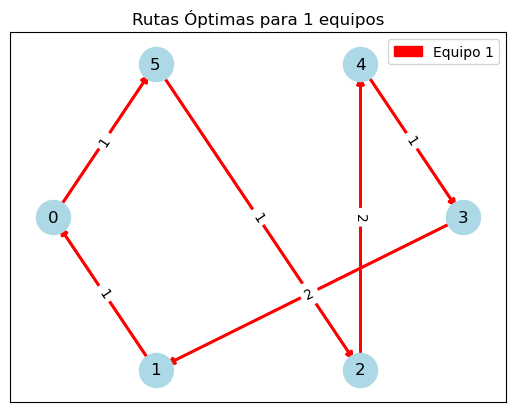

Equipo 1:
  Costo Total: 8.0
  Nodo de Inicio: 0
  Ruta Recorrida: 0 -> 5 -> 2 -> 4 -> 3 -> 1


In [435]:
cost_matrix = [
    [0, 1, 1, 2, 2, 1],
    [1, 0, 3, 2, 3, 3],
    [1, 3, 0, 3, 2, 3],
    [2, 2, 3, 0, 1, 2],
    [2, 3, 3, 1, 0, 3],
    [1, 2, 1, 3, 3, 0]
]


# Definir conjuntos y parámetros
K = [1]
N = [0, 1, 2, 3, 4, 5]  # Localidades
# Matriz de costos en forma de diccionario para Pyomo
c = {(i, j): cost_matrix[i][j] for i in N for j in N}

N_k = {
    1: [0,1,2,3,4,5],
}

s_k = {1: 0}

ejecutar_modelo(K, N, N_k, c, s_k)

## Ejemplo con 2 equipos

Model unknown

  Variables:
    x : Size=72, Index=N*N*K
        Key       : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 0, 2) :     0 :  None :     1 : False :  True : Binary
        (0, 1, 1) :     0 :   0.0 :     1 : False : False : Binary
        (0, 1, 2) :     0 :  None :     1 : False :  True : Binary
        (0, 2, 1) :     0 :   1.0 :     1 : False : False : Binary
        (0, 2, 2) :     0 :  None :     1 : False :  True : Binary
        (0, 3, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 3, 2) :     0 :   0.0 :     1 : False : False : Binary
        (0, 4, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 4, 2) :     0 :   1.0 :     1 : False : False : Binary
        (0, 5, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 5, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 0, 1) :     0 :   1.0 :     1 : False : False : Binary
     

ERROR: evaluating object as numeric value: obj
        (object: <class 'pyomo.core.base.objective.ScalarObjective'>)
    No value for uninitialized NumericValue object x[0,0,1]
        Key : Active : Value
        None :   None :  None

  Constraints:
    leave_city : Size=7
        Key    : Lower : Body : Upper
        (0, 1) :   1.0 :  1.0 :   1.0
        (0, 2) :   1.0 :  1.0 :   1.0
        (1, 1) :   1.0 :  1.0 :   1.0
        (2, 1) :   1.0 :  1.0 :   1.0
        (3, 2) :   1.0 :  1.0 :   1.0
        (4, 2) :   1.0 :  1.0 :   1.0
        (5, 2) :   1.0 :  1.0 :   1.0
    arrive_city : Size=7
        Key    : Lower : Body : Upper
        (0, 1) :   1.0 :  1.0 :   1.0
        (0, 2) :   1.0 :  1.0 :   1.0
        (1, 1) :   1.0 :  1.0 :   1.0
        (2, 1) :   1.0 :  1.0 :   1.0
        (3, 2) :   1.0 :  1.0 :   1.0
        (4, 2) :   1.0 :  1.0 :   1.0
        (5, 2) :   1.0 :  1.0 :   1.0
    flow_constraint : Size=5
        Key    : Lower : Body : Upper
        (1, 1) :   0.0 :

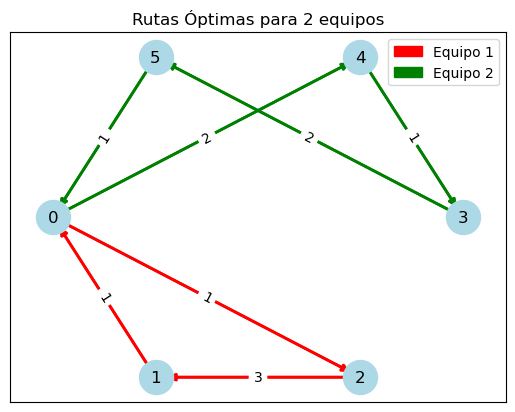

Equipo 1:
  Costo Total: 5.0
  Nodo de Inicio: 0
  Ruta Recorrida: 0 -> 2 -> 1
Equipo 2:
  Costo Total: 6.0
  Nodo de Inicio: 0
  Ruta Recorrida: 0 -> 4 -> 3 -> 5


In [436]:
# Para 2 equipos
K = [1, 2]
N_k = {
    1: [0, 1, 2],  # Equipo 1 visita localidades 0, 1, 2
    2: [0,3, 4, 5]   # Equipo 2 visita localidades 3, 4, 5
}
s_k = {1: 0, 2: 0}  # Ambos equipos empiezan en 0

# Ejecutar modelo
ejecutar_modelo(K, N, N_k, c, s_k)


## Ejemplo con 3 equipos

Model unknown

  Variables:
    x : Size=108, Index=N*N*K
        Key       : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 0, 2) :     0 :  None :     1 : False :  True : Binary
        (0, 0, 3) :     0 :  None :     1 : False :  True : Binary
        (0, 1, 1) :     0 :   1.0 :     1 : False : False : Binary
        (0, 1, 2) :     0 :  None :     1 : False :  True : Binary
        (0, 1, 3) :     0 :  None :     1 : False :  True : Binary
        (0, 2, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 2, 2) :     0 :  None :     1 : False :  True : Binary
        (0, 2, 3) :     0 :   1.0 :     1 : False : False : Binary
        (0, 3, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 3, 2) :     0 :  None :     1 : False :  True : Binary
        (0, 3, 3) :     0 :   0.0 :     1 : False : False : Binary
        (0, 4, 1) :     0 :  None :     1 : False :  True : Binary
    

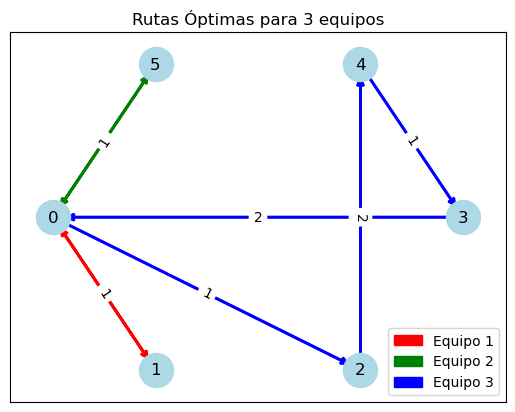

Equipo 1:
  Costo Total: 2.0
  Nodo de Inicio: 0
  Ruta Recorrida: 0 -> 1
Equipo 2:
  Costo Total: 2.0
  Nodo de Inicio: 0
  Ruta Recorrida: 0 -> 5
Equipo 3:
  Costo Total: 6.0
  Nodo de Inicio: 0
  Ruta Recorrida: 0 -> 2 -> 4 -> 3


In [437]:
# Para 3 equipos
K = [1, 2, 3]
N_k = {
    1: [0, 1],
    2: [0,5],
    3: [0,2,3,4]
}
s_k = {1: 0, 2: 0, 3: 0}

# Ejecutar modelo
ejecutar_modelo(K, N, N_k, c, s_k)


## Ejemplo con 5 equipos

Model unknown

  Variables:
    x : Size=500, Index=N*N*K
        Key       : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 0, 2) :     0 :  None :     1 : False :  True : Binary
        (0, 0, 3) :     0 :  None :     1 : False :  True : Binary
        (0, 0, 4) :     0 :  None :     1 : False :  True : Binary
        (0, 0, 5) :     0 :  None :     1 : False :  True : Binary
        (0, 1, 1) :     0 :   1.0 :     1 : False : False : Binary
        (0, 1, 2) :     0 :  None :     1 : False :  True : Binary
        (0, 1, 3) :     0 :  None :     1 : False :  True : Binary
        (0, 1, 4) :     0 :  None :     1 : False :  True : Binary
        (0, 1, 5) :     0 :  None :     1 : False :  True : Binary
        (0, 2, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 2, 2) :     0 :  None :     1 : False :  True : Binary
        (0, 2, 3) :     0 :  None :     1 : False :  True : Binary
    

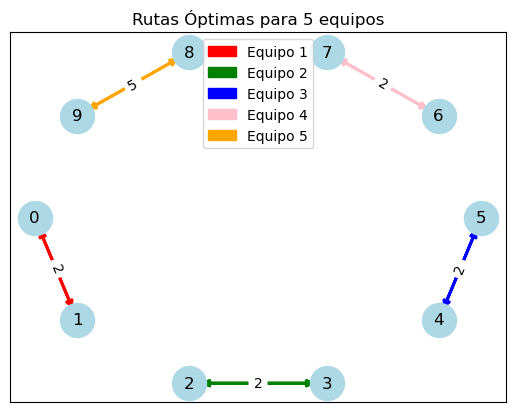

Equipo 1:
  Costo Total: 4.0
  Nodo de Inicio: 0
  Ruta Recorrida: 0 -> 1
Equipo 2:
  Costo Total: 4.0
  Nodo de Inicio: 2
  Ruta Recorrida: 2 -> 3
Equipo 3:
  Costo Total: 4.0
  Nodo de Inicio: 4
  Ruta Recorrida: 4 -> 5
Equipo 4:
  Costo Total: 4.0
  Nodo de Inicio: 6
  Ruta Recorrida: 6 -> 7
Equipo 5:
  Costo Total: 10.0
  Nodo de Inicio: 8
  Ruta Recorrida: 8 -> 9


In [438]:
# Matriz de costos para 5 equipos (10 localidades)
cost_matrix_5 = [
    [0, 2, 4, 6, 8, 3, 5, 7, 9, 2],
    [2, 0, 3, 5, 7, 4, 6, 8, 1, 3],
    [4, 3, 0, 2, 6, 5, 3, 7, 2, 4],
    [6, 5, 2, 0, 4, 6, 5, 3, 1, 5],
    [8, 7, 6, 4, 0, 2, 4, 6, 3, 7],
    [3, 4, 5, 6, 2, 0, 3, 5, 4, 3],
    [5, 6, 3, 5, 4, 3, 0, 2, 6, 4],
    [7, 8, 7, 3, 6, 5, 2, 0, 4, 6],
    [9, 1, 2, 1, 3, 4, 6, 4, 0, 5],
    [2, 3, 4, 5, 7, 3, 4, 6, 5, 0]
]

# Definir conjuntos y parámetros
K = [1, 2, 3, 4, 5]  # 5 equipos
N = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # 10 localidades

# Asignaciones de localidades para 5 equipos
N_k = {
    1: [0, 1],          # Equipo 1 visita localidades 0, 1
    2: [2, 3],          # Equipo 2 visita localidades 2, 3
    3: [4, 5],          # Equipo 3 visita localidades 4, 5
    4: [6, 7],          # Equipo 4 visita localidades 6, 7
    5: [8, 9]           # Equipo 5 visita localidades 8, 9
}
s_k = {1: 0, 2: 2, 3: 4, 4: 6, 5: 8}  # Cada equipo comienza en su primera localidad asignada

# Ejecutar modelo
ejecutar_modelo(K, N, N_k, {(i, j): cost_matrix_5[i][j] for i in N for j in N}, s_k)



## Ejemplo con 8 equipos

Model unknown

  Variables:
    x : Size=2048, Index=N*N*K
        Key         : Lower : Value : Upper : Fixed : Stale : Domain
          (0, 0, 1) :     0 :  None :     1 : False :  True : Binary
          (0, 0, 2) :     0 :  None :     1 : False :  True : Binary
          (0, 0, 3) :     0 :  None :     1 : False :  True : Binary
          (0, 0, 4) :     0 :  None :     1 : False :  True : Binary
          (0, 0, 5) :     0 :  None :     1 : False :  True : Binary
          (0, 0, 6) :     0 :  None :     1 : False :  True : Binary
          (0, 0, 7) :     0 :  None :     1 : False :  True : Binary
          (0, 0, 8) :     0 :  None :     1 : False :  True : Binary
          (0, 1, 1) :     0 :   1.0 :     1 : False : False : Binary
          (0, 1, 2) :     0 :  None :     1 : False :  True : Binary
          (0, 1, 3) :     0 :  None :     1 : False :  True : Binary
          (0, 1, 4) :     0 :  None :     1 : False :  True : Binary
          (0, 1, 5) :     0 :  None :     1 

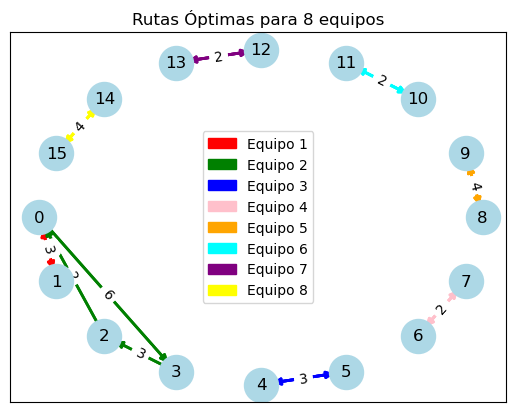

Equipo 1:
  Costo Total: 6.0
  Nodo de Inicio: 0
  Ruta Recorrida: 0 -> 1
Equipo 2:
  Costo Total: 11.0
  Nodo de Inicio: 0
  Ruta Recorrida: 0 -> 3 -> 2
Equipo 3:
  Costo Total: 6.0
  Nodo de Inicio: 4
  Ruta Recorrida: 4 -> 5
Equipo 4:
  Costo Total: 4.0
  Nodo de Inicio: 6
  Ruta Recorrida: 6 -> 7
Equipo 5:
  Costo Total: 8.0
  Nodo de Inicio: 8
  Ruta Recorrida: 8 -> 9
Equipo 6:
  Costo Total: 4.0
  Nodo de Inicio: 10
  Ruta Recorrida: 10 -> 11
Equipo 7:
  Costo Total: 4.0
  Nodo de Inicio: 12
  Ruta Recorrida: 12 -> 13
Equipo 8:
  Costo Total: 8.0
  Nodo de Inicio: 14
  Ruta Recorrida: 14 -> 15


In [439]:
# Matriz de costos para 8 equipos (16 localidades)
cost_matrix_8 = [
    [0, 3, 2, 6, 7, 1, 4, 8, 5, 2, 9, 3, 4, 6, 7, 5],
    [3, 0, 4, 5, 8, 2, 6, 7, 3, 4, 1, 6, 8, 5, 4, 3],
    [2, 4, 0, 3, 6, 4, 2, 5, 1, 6, 8, 4, 7, 3, 2, 8],
    [6, 5, 3, 0, 4, 5, 3, 2, 8, 7, 6, 3, 4, 2, 5, 1],
    [7, 8, 6, 4, 0, 3, 5, 4, 2, 3, 6, 7, 2, 1, 3, 8],
    [1, 2, 4, 5, 3, 0, 6, 8, 7, 2, 5, 4, 6, 3, 7, 9],
    [4, 6, 2, 3, 5, 6, 0, 2, 3, 7, 5, 8, 4, 6, 1, 4],
    [8, 7, 5, 2, 4, 8, 2, 0, 1, 3, 4, 7, 6, 4, 3, 5],
    [5, 3, 1, 8, 2, 7, 3, 1, 0, 4, 5, 6, 8, 3, 2, 4],
    [2, 4, 6, 7, 3, 2, 7, 3, 4, 0, 3, 5, 6, 4, 7, 8],
    [9, 1, 8, 6, 6, 5, 5, 4, 5, 3, 0, 2, 4, 5, 6, 3],
    [3, 6, 4, 3, 7, 4, 8, 7, 6, 5, 2, 0, 1, 2, 3, 6],
    [4, 8, 7, 4, 2, 6, 4, 6, 8, 6, 4, 1, 0, 2, 4, 3],
    [6, 5, 3, 2, 1, 3, 6, 4, 3, 4, 5, 2, 2, 0, 3, 7],
    [7, 4, 2, 5, 3, 7, 1, 3, 2, 7, 6, 3, 4, 3, 0, 4],
    [5, 3, 8, 1, 8, 9, 4, 5, 4, 8, 3, 6, 3, 7, 4, 0]
]

# Definir conjuntos y parámetros
K = [1, 2, 3, 4, 5, 6, 7, 8]  # 8 equipos
N = [i for i in range(16)]  # 16 localidades

# Asignaciones de localidades para 8 equipos
N_k = {
    1: [0, 1],     # Equipo 1 visita localidades 0, 1
    2: [0,2, 3],     # Equipo 2 visita localidades 2, 3
    3: [4, 5],     # Equipo 3 visita localidades 4, 5
    4: [6, 7],     # Equipo 4 visita localidades 6, 7
    5: [8, 9],     # Equipo 5 visita localidades 8, 9
    6: [10, 11],   # Equipo 6 visita localidades 10, 11
    7: [12, 13],   # Equipo 7 visita localidades 12, 13
    8: [14, 15]    # Equipo 8 visita localidades 14, 15
}
s_k = {1: 0, 2: 0, 3: 4, 4: 6, 5: 8, 6: 10, 7: 12, 8: 14}  # Cada equipo comienza en su primera localidad asignada

# Ejecutar modelo
ejecutar_modelo(K, N, N_k, {(i, j): cost_matrix_8[i][j] for i in N for j in N}, s_k)

